In [1]:
%%capture
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%capture captured
CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = len(CLASS_NAMES)
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())
model.load_weights("/home/kabilan/Desktop/caption/dataset/mask_rcnn_coco.h5", by_name=True)

2022-05-01 08:46:39.161094: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-01 08:46:44.538109: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-01 08:46:44.538170: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kabilan-pt4987): /proc/driver/nvidia/version does not exist
2022-05-01 08:46:44.540365: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-01 08:46:44.567226: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2599990000 Hz
2022-05-01 08:46:44.568516: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f54519d8e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-01

In [3]:
class Node:
    def __init__(self,start,end,class_id,class_name):
        self.start = start
        self.end = end
        self.class_id = class_id
        self.class_name = class_name

In [4]:
def get_objects_and_locations(image_path):
    image = cv2.imread(image_path,1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    rois = model.detect([image], verbose=0)[0]
    return rois

def get_angle(node_a,node_b):
    x1,y1 = node_a.end
    x2,y2 = node_b.end
    tan = (y2-y1)/(x2-x1)
    return tan

def distance(node_a,node_b):
    return np.linalg.norm(np.array(node_a.end) - np.array(node_b.end))

def get_position_word(node_a,node_b):
    angle = get_angle(node_a,node_b)
    if angle < BEHIND_THRES:
        return prepare_sentence(node_b,node_a,BEHIND_WORD)
    elif angle > FRONT_THRES:
        return prepare_sentence(node_b,node_a,FRONT_WORD)
    return prepare_sentence(node_a,node_b,NEAR_WORD)

def prepare_sentence(node_a,node_b,join_word):
    return f"{node_a.reference_name} is {join_word} {node_b.reference_name}"

def process_sentence_objects(objects):
    if len(objects) < 0:
        print(f"a {objects[0].class_name} is in front of you.")
    i=0
    while i< len(objects)-1:
        node_a = objects[i]
        node_b = objects[i+1]
        print(get_position_word(node_a,node_b))
        i+=1
        
def add_node_reference_name(objects):
    objects_count_dict = {}
    for each in objects:
        if each.class_id in objects_count_dict:
            objects_count_dict[each.class_id] +=1
        else:
            objects_count_dict[each.class_id] =1
        each.reference_name = each.class_name + " " + str(objects_count_dict[each.class_id])
        
def create_nodes(res):
    objects = []
    for i in range(len(res['rois'])):
        class_name = CLASS_NAMES[res['class_ids'][i]]
        class_id = res['class_ids'][i]
        points = res['rois'][i]
        start = (points[1],points[0])
        end = (points[3],points[2])
        score = res['scores'][i]
        ob = Node(start,end,class_id,class_name)
        if score > 0.9:
            objects.append(ob)
    add_node_reference_name(objects)
    return objects

In [5]:
BEHIND_THRES = -0.2
FRONT_THRES = 0.2
BEHIND_WORD = "behind"
FRONT_WORD = "front of"
NEAR_WORD = "near"

In [6]:
def process_objects(image_path):
    res =  get_objects_and_locations(image_path)
    objects = create_nodes(res)
    process_sentence_objects(objects)
    

In [7]:
img_path="/home/kabilan/Desktop/caption/dataset/images/"

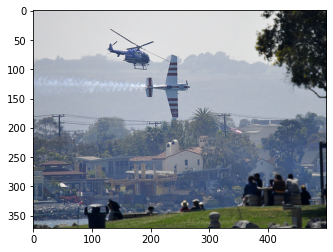

airplane 2 is front of airplane 1
person 1 is front of airplane 2
person 1 is near person 2
person 2 is near person 3
person 3 is near person 4
person 4 is near person 5
person 5 is near person 6
person 6 is near person 7
person 7 is near person 8
person 8 is near person 9
person 10 is front of person 9


In [8]:
process_objects(img_path+"3522025527_c10e6ebd26.jpg")